# Dog Breed Classification


---
L Rant


---
Juin 2019


In [ ]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/dog/
!ls

!unzip train.zip

#*1*.Introduction

The objectif is to predict the breed of a dog given an input image of a dog . We take only the breed's Top 30

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#*2*.Loading Dataset

In [ ]:
#import the neccesary packages
import pandas as pd
import numpy as np
from random import randint
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
#constants
num_classes = 80 # the number of breeds we want to classify
seed = 42 # makes the random numbers in numpy predictable
im_size = 299 # This size of the images
batch_size = 32
path = '/content/drive/My Drive/Colab Notebooks/dog/'
#read the csv into a dataframe, group the breeds and 
df = pd.read_csv(path+'labels.csv')



In [ ]:
selected_breed_list = list(df.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)
selected_breed_list
df = df[df['breed'].isin(selected_breed_list)]
df['filename'] = df.apply(lambda x: ('train/' + x['id'] + '.jpg'), axis=1)


breeds = pd.Series(df['breed'])
print("total number of breeds to classify",len(breeds.unique()))

df.head()

total number of breeds to classify 80


,id,breed,filename
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier,train/002211c81b498ef88e1b40b9abf84e1d.jpg
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier,train/00290d3e1fdd27226ba27a8ce248ce85.jpg


In [ ]:
print(df.groupby('breed').count().sort_values(by='id', ascending=False))

breeds = pd.Series(df['breed'])
print("total number of breeds to classify",len(breeds.unique()))

                            id  filename
breed                                   
scottish_deerhound         126       126
maltese_dog                117       117
afghan_hound               116       116
entlebucher                115       115
bernese_mountain_dog       114       114
...                        ...       ...
toy_terrier                 79        79
miniature_poodle            79        79
staffordshire_bullterrier   79        79
sussex_spaniel              78        78
norwich_terrier             78        78

[80 rows x 2 columns]
total number of breeds to classify 80


## Breed TOP 30

                             id  filename
breed                                    
weimaraner                   85        85
labrador_retriever           84        84
saint_bernard                84        84
norfolk_terrier              83        83
chesapeake_bay_retriever     83        83
english_setter               83        83
scotch_terrier               82        82
wire-haired_fox_terrier      82        82
yorkshire_terrier            82        82
kerry_blue_terrier           82        82
irish_terrier                82        82
groenendael                  82        82
greater_swiss_mountain_dog   82        82
basset                       82        82
malamute                     81        81
keeshond                     81        81
west_highland_white_terrier  81        81
gordon_setter                81        81
affenpinscher                80        80
dingo                        80        80
mexican_hairless             80        80
clumber                      80   

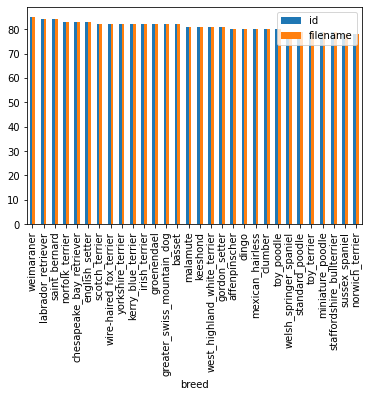

In [ ]:
print(df.groupby("breed").count().sort_values("id", ascending=False).tail(30))
df.groupby("breed").count().sort_values("id", ascending=False).tail(30).plot(kind='bar')

#*3*. Basic Visualization

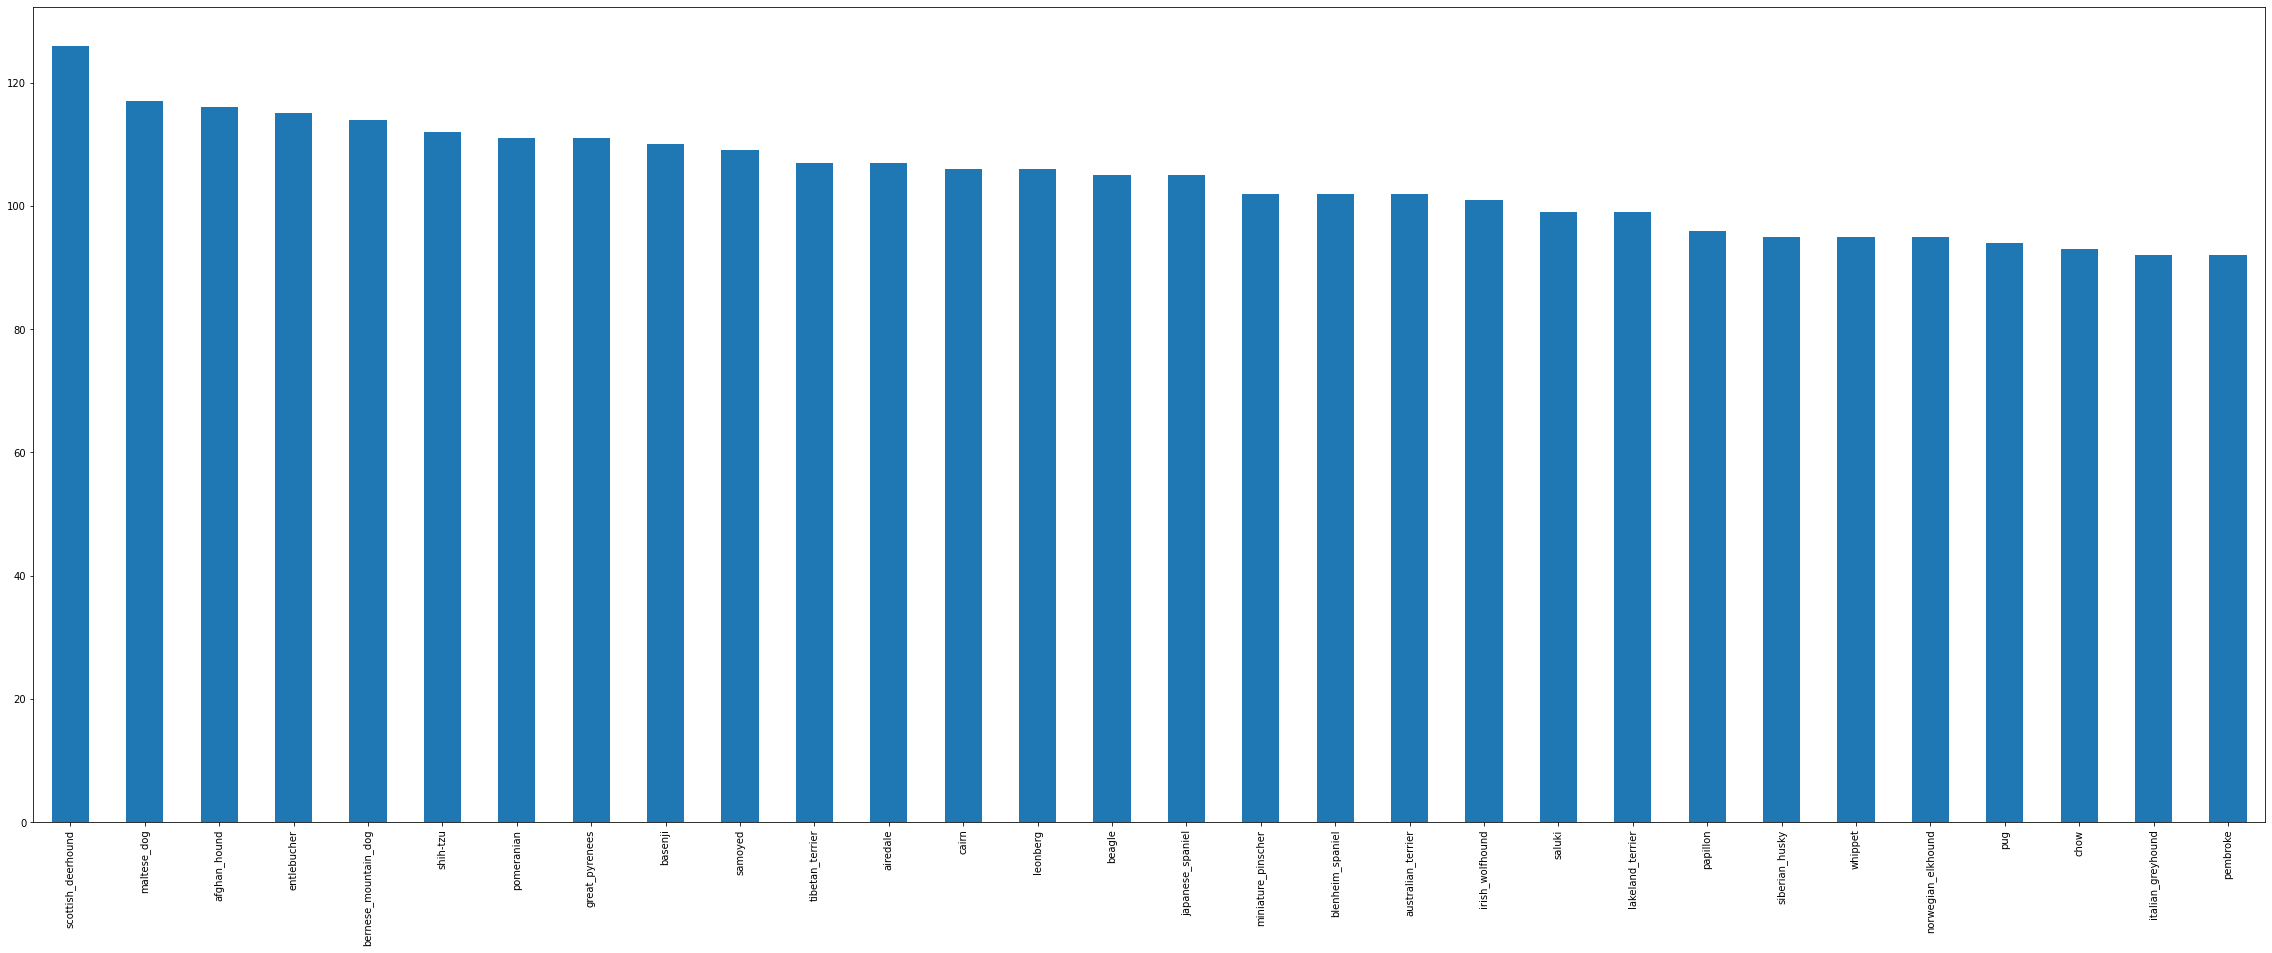

In [ ]:
top_30=list(df.breed.value_counts()[0:30].index)
plt.figure(figsize=(40,15))
df.breed.value_counts()[0:30].plot(kind='bar')
plt.show()

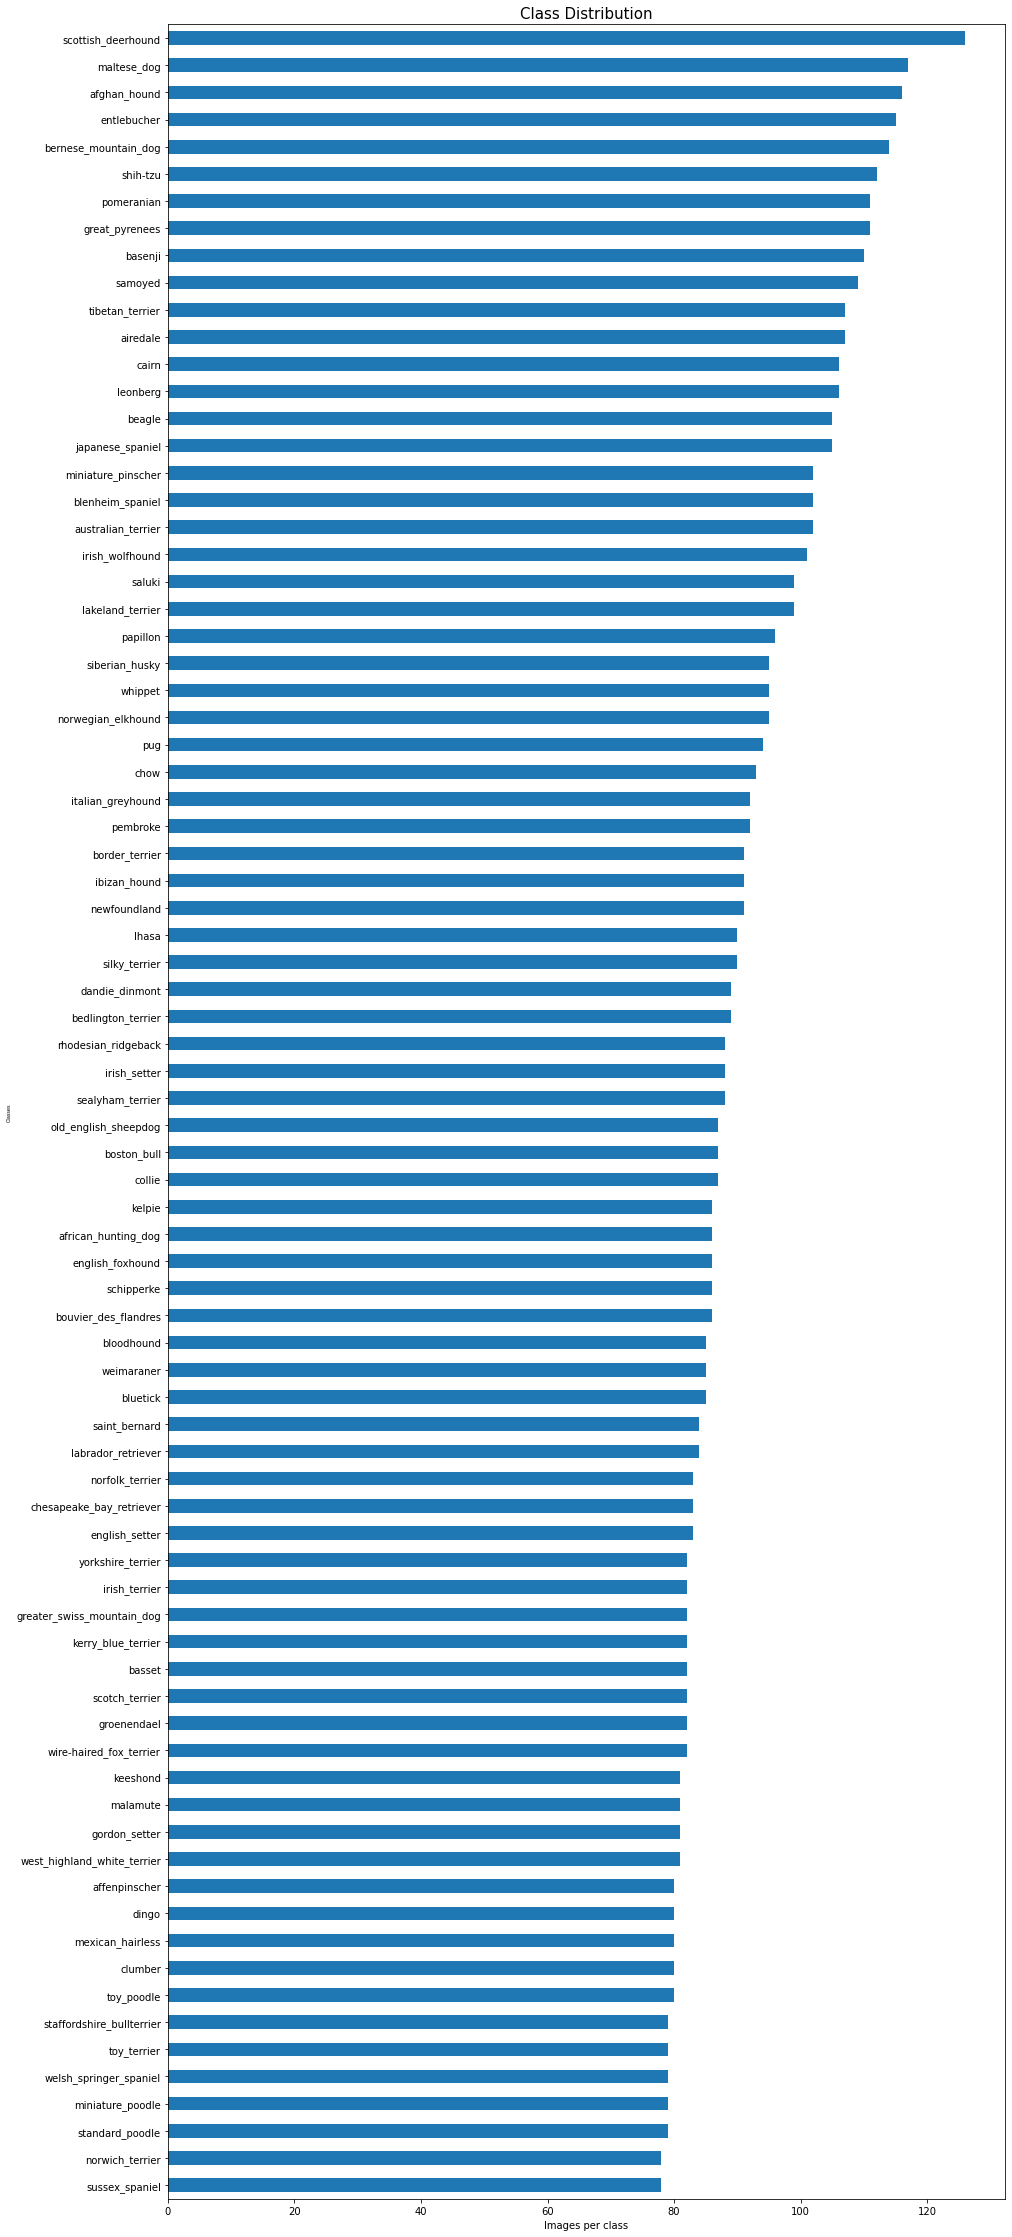

In [ ]:
ax=pd.value_counts(df['breed'],ascending=True).plot(kind='barh',
                                                       fontsize="10",
                                                       title="Class Distribution",
                                                       figsize=(15,40))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(10)
ax.yaxis.label.set_size(5)
ax.title.set_size(15)

In [ ]:
def plot_images(images, classes):
    assert len(images) == len(classes) == 9
    img_width1 = 250
    img_height1 = 250
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3,figsize=(10,10),sharex=True)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.

        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB).reshape(img_width1,img_height1,3), cmap='hsv')
        xlabel = "Breed: {0}".format(classes[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        ax.xaxis.label.set_size(10)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.

In [ ]:
img_width1 = 250
img_height1 = 250
images=[]
classes=[]
image_dir = '/content/drive/My Drive/Colab Notebooks/dog/train/'
#load training images
for f, breed in tqdm(df.values):
    img = cv2.imread(image_dir+'{}.jpg'.format(f))
    classes.append(breed)
    images.append(cv2.resize(img, (img_width1, img_height1)))

  0%|          | 0/7323 [00:00<?, ?it/s]


ValueError: ignored

In [ ]:
# select random images
random_numbers = [randint(0, len(images)) for p in range(0,9)]
images_to_show = [images[i] for i in random_numbers]
classes_to_show = [classes[i] for i in random_numbers]
print(random_numbers)
#print(images_to_show)
print(classes_to_show)
print("Images to show: {0}".format(len(images_to_show)))
print("Classes to show: {0}".format(len(classes_to_show)))

#plot the images
plot_images(images_to_show, classes_to_show)

IndexError: ignored

#4.Train test Split

In [ ]:
from keras.preprocessing import image

def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    path =  train_or_test + "/" + img_id + ".jpg"
    img = image.load_img(path, target_size=size)
    return image.img_to_array(img)

In [ ]:
from sklearn.preprocessing import LabelEncoder
seed=42
label_enc = LabelEncoder()
np.random.seed(seed=seed)
rnd = np.random.random(len(df))
train_idx = rnd < 0.9
valid_idx = rnd >= 0.9
y_train = label_enc.fit_transform(df["breed"].values)
ytr = y_train[train_idx]
yv = y_train[valid_idx]

In [ ]:
from tqdm import tqdm
from keras.applications import xception
from keras.preprocessing import image
import numpy as np
x_train = np.zeros((train_idx.sum(), im_size, im_size, 3), dtype='float32')
x_valid = np.zeros((valid_idx.sum(), im_size, im_size, 3), dtype='float32')
train_i = 0
valid_i = 0
for i, img_id in tqdm(enumerate(df['id'])):
    img = read_img(img_id, path +'train', (im_size, im_size))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    if train_idx[i]:
        x_train[train_i] = x
        train_i += 1
    elif valid_idx[i]:
        x_valid[valid_i] = x
        valid_i += 1
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

7323it [42:35,  2.87it/s]

Train Images shape: (6595, 299, 299, 3) size: 1,768,798,785


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow(x_train, 
                                     ytr, 
                                     batch_size=batch_size)


valid_datagen = ImageDataGenerator()

valid_generator = valid_datagen.flow(x_valid, 
                                     yv, 
                                     batch_size=batch_size)


## The model of prediction Convolutional Network

In [ ]:

from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input

# create the base pre-trained model
base_model = xception.Xception(weights='imagenet', include_top=False)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer and set it to the number of breeds we want to classifiy, 
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

## Training of the model

In [ ]:
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 10
learning_rate = 0.001

# checkpoints
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
STAMP = "{}_dog_breed_model".format(datetime.date.today().strftime("%Y-%m-%d"))

bst_model_path = "{}.h5".format(STAMP)
model_checkpoint = ModelCheckpoint(bst_model_path,
                                   save_best_only=True,
                                   save_weights_only=False,
                                  verbose=1)



# compile the model (should be done *after* setting layers to non-trainable)
optimizer = RMSprop(lr=learning_rate, rho=0.9)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

hist = model.fit_generator(train_generator,
                           steps_per_epoch=train_idx.sum() // batch_size,
                           epochs=epochs, callbacks=[early_stopping, model_checkpoint],
                           validation_data=valid_generator,
                           validation_steps=valid_idx.sum() // batch_size)

# serialize weights to HDF5
model.save(path+bst_model_path)
print("Saved model to disk")

#5.Results Accuracy & Loss

In [ ]:
import matplotlib.pyplot as plt
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
bst_model_path="/content/drive/My Drive/Colab Notebooks/dog/2019-11-18_dog_breed_model.h5"
from tensorflow.keras import layers
reloaded = tf.keras.models.load_model(bst_model_path, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()
model=reloaded

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os


def predict_from_image(img_path):

    img = image.load_img(img_path, target_size=(299, 299))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    
    pred = model.predict(img_tensor)
    sorted_breeds_list = sorted(selected_breed_list)
    predicted_class = sorted_breeds_list[np.argmax(pred)]
    
    plt.imshow(img_tensor[0])                           
    plt.axis('off')
    plt.show()

    return predicted_class

#6.Test prediction image Dog

In [ ]:
df.head(10)

,id,breed,filename
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier,train/002211c81b498ef88e1b40b9abf84e1d.jpg
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier,train/00290d3e1fdd27226ba27a8ce248ce85.jpg
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,train/003df8b8a8b05244b1d920bb6cf451f9.jpg
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,train/0042188c895a2f14ef64a918ed9c7b64.jpg
12,00693b8bc2470375cc744a6391d397ec,maltese_dog,train/00693b8bc2470375cc744a6391d397ec.jpg
13,006cc3ddb9dc1bd827479569fcdc52dc,bluetick,train/006cc3ddb9dc1bd827479569fcdc52dc.jpg
14,0075dc49dab4024d12fafe67074d8a81,norfolk_terrier,train/0075dc49dab4024d12fafe67074d8a81.jpg


In [ ]:
df.sample(10)

,id,breed,filename
7721,c1486d60b3c8c6b1b02b6e13363f5cef,chesapeake_bay_retriever,train/c1486d60b3c8c6b1b02b6e13363f5cef.jpg
6938,ae1aeb3bb01b156aad5db0bbdd7cf6d9,basset,train/ae1aeb3bb01b156aad5db0bbdd7cf6d9.jpg
215,04f59d1b6887cf10e6fd897514623cf3,chesapeake_bay_retriever,train/04f59d1b6887cf10e6fd897514623cf3.jpg
4382,6d49de8f03116d2fcf3eb6942a9c6233,airedale,train/6d49de8f03116d2fcf3eb6942a9c6233.jpg
5691,8f98905c8a1010074eb939c26734ef5e,groenendael,train/8f98905c8a1010074eb939c26734ef5e.jpg
1842,2d5f90898716876858ff1bf7f418d7d7,groenendael,train/2d5f90898716876858ff1bf7f418d7d7.jpg
7986,c7b05bd8992c6c7653e219d3242c01c4,pembroke,train/c7b05bd8992c6c7653e219d3242c01c4.jpg
5069,806cbcc0362d78eabe9930ccd9b1c184,norfolk_terrier,train/806cbcc0362d78eabe9930ccd9b1c184.jpg
3898,60e3cce8294a0eb07f089e59faa1d15a,border_terrier,train/60e3cce8294a0eb07f089e59faa1d15a.jpg
5032,7f5723c0d512b52da81943350b107d87,bernese_mountain_dog,train/7f5723c0d512b52da81943350b107d87.jpg


                breed
5069  norfolk_terrier


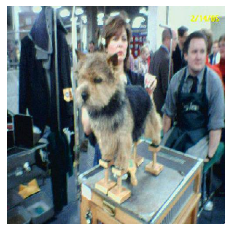

'norwich_terrier'

In [ ]:
# image path
#!wget https://www.canalvie.com/polopoly_fs/1.1804714.1467920015!/image/chien-saint-bernard.jpg_gen/derivatives/cvlandscape_670_377/chien-saint-bernard.jpg
#img_path = '/content/drive/My Drive/Colab Notebooks/dogcatfilter/cats_and_dogs_filtered/validation/dogs/dog.2128.jpg'
img_path = '/content/drive/My Drive/Colab Notebooks/dog/train/806cbcc0362d78eabe9930ccd9b1c184.jpg'
#img_path="chien-saint-bernard.jpg" # dog

print(df.loc[df['id']== "806cbcc0362d78eabe9930ccd9b1c184",["breed"]])

predict_from_image(img_path)

In [ ]:
df.loc[df['id']== "806cbcc0362d78eabe9930ccd9b1c184",["breed"]]


,breed
5069,norfolk_terrier
